# Rusty Bargain

# Contents<a id='back'></a>

* [Introducción](#intro)
* [Inicialización](#inicializacion)
* [Cargando los datos](#cargando_los_datos)
* [Explorando los datos](#explorando_datos_iniciales)
* [Preparación de datos](#preparacion_de_datos)
* [Entrenamiento del modelo](#entrenamiento_del_modelo)
* [Conclusión general](#end)

## Introducción <a id='intro'></a>
**Propósito del proyecto**
    
   - Crear un modelo que determine el valor de mercado para la compañía Rusty Bargain

### Objetivos:
1. - Entrenar diferentes modelos con varios hiperparámetros;
2. - Comparar métodos de potenciación del gradiente con bosque aleatorio, árbol de decisión y regresión lineal;
3. - Analizar la velocidad y la calidad de los modelos.

[Volver a Contenidos](#back)

## Inicialización <a id='inicializacion'></a>

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgbm

[Volver a Contenidos](#back)

## Cargando los datos <a id='cargando_los_datos'></a>

In [2]:
# leyendo el archivo y almacenándolo en df
df = pd.read_csv('/datasets/car_data.csv')

## Explorando los datos <a id='explorando_datos_iniciales'></a>

**Descripción de datos**

In [3]:
df.shape

(354369, 16)

In [4]:
# Imprimiendo la información general/resumen sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
95%,14600.000000,2016.000000,218.000000,150000.000000,12.000000,0.0,93109.000000
99%,18800.000000,2018.000000,300.000000,150000.000000,12.000000,0.0,98596.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.describe(exclude=['int', 'float'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05/03/2016 14:25,sedan,manual,golf,petrol,volkswagen,no,03/04/2016 00:00,07/04/2016 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654


In [7]:
# Imprime una muestra de los datos
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


**Valores ausentes**

In [8]:
df.isna().sum().sort_values(ascending=False)

NotRepaired          71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
df.isna().sum().sort_values(ascending=False) / len(df) * 100

NotRepaired          20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Mileage               0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

**Valores duplicados**

In [10]:
len(df.drop_duplicates()) == len(df)

False

**Conclusión intermedia**
 - El DataFrame **df** tiene 354.369 filas y 16 columnas. Con valores ausentes, y valores duplicados.

[Volver a Contenidos](#back)

## Preparación de datos <a id='preparacion_de_datos'></a>

### **Inspeccionando los valores únicos**

In [11]:
# inspeccionando los nombres únicos
df['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [12]:
# inspeccionando los nombres únicos
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [13]:
# inspeccionando los nombres únicos
df['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

In [14]:
# inspeccionando los nombres únicos
df["Model"]= df["Model"].astype("str").str.strip()
sorted(df["Model"].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [15]:
# inspeccionando los nombres únicos
df['Mileage'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

In [16]:
# inspeccionando los nombres únicos
df['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [17]:
# inspeccionando los nombres únicos
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [18]:
# inspeccionando los nombres únicos
df['NotRepaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

In [19]:
# inspeccionando los nombres únicos
df['NumberOfPictures'].sort_values().unique()

array([0])

In [20]:
# inspeccionando los nombres únicos
df['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

### Estilo del encabezado
Imprimiendo el encabezado de la columna

In [21]:
# la lista de los nombres de las columnas en la tabla df
df.columns.sort_values()

Index(['Brand', 'DateCrawled', 'DateCreated', 'FuelType', 'Gearbox',
       'LastSeen', 'Mileage', 'Model', 'NotRepaired', 'NumberOfPictures',
       'PostalCode', 'Power', 'Price', 'RegistrationMonth', 'RegistrationYear',
       'VehicleType'],
      dtype='object')

In [22]:
# renombra las columnas
df.rename(
    columns={
        'Brand': 'brand',
        'DateCrawled': 'date_crawled',
        'DateCreated': 'date_created',
        'FuelType': 'fuel_type',
        'Gearbox': 'gearbox',
        'LastSeen': 'last_seen',
        'Mileage': 'mileage',
        'Model': 'model',
        'NotRepaired': 'not_repaired',
        'NumberOfPictures': 'number_of_pictures',
        'PostalCode': 'postal_code',
        'Power': 'power',
        'Price': 'price',
        'RegistrationMonth': 'registration_month',
        'RegistrationYear': 'registration_year',
        'VehicleType': 'vehicle_type',
    }, inplace=True
)

In [23]:
# comprobando el resultado: la lista de los nombres de las columnas
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [24]:
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen', 'number_of_pictures'], axis=1)
df

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,nan,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


### Restaurando valores ausentes <a id='restaurando_valores_ausentes'></a>

In [25]:
df_notnan = df.dropna()
df_notnan.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


#### Restaurar valores ausentes en `not_repaired`

In [26]:
def not_repaired_category(not_repaired):
    if not_repaired == "yes":
        return "uno"
    else:
        return "dos"

In [27]:
print(not_repaired_category("yes"))

uno


In [28]:
# Creando una nueva columna basada en la función
df_notnan["not_repaired_category"] = df_notnan["not_repaired"].apply(not_repaired_category)

/tmp/ipykernel_158/2579941818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnan["not_repaired_category"] = df_notnan["not_repaired"].apply(not_repaired_category)


In [29]:
# Comprobando cómo los valores en la nueva columna
df_notnan.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,not_repaired_category
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,uno
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,dos
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,dos
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,uno
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,dos


In [30]:
w = (
    df_notnan
    .groupby(["vehicle_type", "model", "not_repaired"])["not_repaired_category"]
    .count()
    .reset_index()
    .sort_values(by=["vehicle_type", "not_repaired_category"], ascending=False)
)

w.head()

,vehicle_type,model,not_repaired,not_repaired_category
1607,wagon,passat,no,4978
1441,wagon,a4,no,3916
1419,wagon,3er,no,3483
1444,wagon,a6,no,2420
1478,wagon,c_klasse,no,2336


In [31]:
not_repaired_= w.groupby("vehicle_type").head(1).drop(columns="not_repaired_category").set_index("vehicle_type")
not_repaired_

,model,not_repaired
vehicle_type,,
wagon,passat,no
suv,other,no
small,polo,no
sedan,golf,no
other,other,no
coupe,3er,no
convertible,3er,no
bus,other,no


In [32]:
#Función que usaremos para completar los valores ausentes
def nr(row):
    not_repaired = row["not_repaired"]
    vehicle_type = row["vehicle_type"]
    model = row["model"]
    if pd.isna(not_repaired):
        try:
            return not_repaired_["not_repaired"][vehicle_type]
        except:
            return not_repaired_["not_repaired"].mode()
    return not_repaired

In [33]:
# Comprobando si funciona
df.apply(nr, axis=1).isna().sum()

0    0
dtype: int64

In [34]:
# Aplicando la función
df["not_repaired"] = df.apply(nr, axis=1)
df["not_repaired"].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [35]:
# Not repaired
df["not_repaired"] = df["not_repaired"].replace("yes", 1)
df["not_repaired"] = df["not_repaired"].replace("no", 0)

In [36]:
# inspeccionando los nombres únicos
df["not_repaired"].sort_values().unique()

array([0, 1])

#### Restaurar valores ausentes en `VehicleType`

In [37]:
def vehicle_type_category(vehicle_type):
    if vehicle_type == "bus":
        return "bus"
    elif vehicle_type == "convertible":
        return "convertible"
    elif vehicle_type == "coupe":
        return "coupe"
    elif vehicle_type == "other":
        return "other"
    elif vehicle_type == "sedan":
        return "sedan"
    elif vehicle_type == "small":
        return "small"
    elif vehicle_type == "suv":
        return "suv"
    elif vehicle_type == "wagon":
        return "wagon"
    else:
        return "Sin información"

In [38]:
print(vehicle_type_category("sedan"))

sedan


In [39]:
# Creando una nueva columna basada en la función
df_notnan["vehicle_type_category"] = df_notnan["vehicle_type"].apply(vehicle_type_category)

/tmp/ipykernel_158/1069360709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnan["vehicle_type_category"] = df_notnan["vehicle_type"].apply(vehicle_type_category)


In [40]:
# Comprobando cómo los valores en la nueva columna
df_notnan.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,not_repaired_category,vehicle_type_category
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,uno,coupe
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,dos,small
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,dos,small
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,uno,sedan
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,dos,convertible


In [41]:
x = (
    df_notnan
    .groupby(["brand", "model", "vehicle_type"])["vehicle_type_category"]
    .count()
    .reset_index()
    .sort_values(by=["brand", "vehicle_type_category"], ascending=False)
)

x.head()

,brand,model,vehicle_type,vehicle_type_category
1504,volvo,v40,wagon,530
1510,volvo,v70,wagon,525
1497,volvo,other,sedan,300
1506,volvo,v50,wagon,220
1512,volvo,xc_reihe,suv,201


In [42]:
vehicle_type_= x.groupby("brand").head(1).drop(columns="vehicle_type_category").set_index("brand")
vehicle_type_

,model,vehicle_type
brand,,
volvo,v40,wagon
volkswagen,golf,sedan
trabant,601,sedan
toyota,yaris,small
suzuki,swift,small
subaru,impreza,sedan
sonstige_autos,nan,sedan
smart,fortwo,small
skoda,octavia,wagon


In [43]:
#Función que usaremos para completar los valores ausentes
def vt(row):
    model = row["model"]
    vehicle_type = row["vehicle_type"]
    brand = row["brand"]
    if pd.isna(vehicle_type):
        try:
            return vehicle_type_["vehicle_type"][brand]
        except:
            return vehicle_type_["vehicle_type"].mode()
    return vehicle_type

In [44]:
# Comprobando si funciona
df.apply(vt, axis=1).isna().sum()

0

In [45]:
# Aplicando la función
df["vehicle_type"] = df.apply(vt, axis=1)
df["vehicle_type"].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon'], dtype=object)

#### Restaurar valores ausentes en `FuelType`

In [46]:
def fuel_type_category(fuel_type):
    if fuel_type == "cng":
        return "cng"
    elif fuel_type == "electric":
        return "electric"
    elif fuel_type == "gasoline":
        return "gasoline"
    elif fuel_type == "hybrid":
        return "hybrid"
    elif fuel_type == "lpg":
        return "lpg"
    elif fuel_type == "other":
        return "other"
    elif fuel_type == "petrol":
        return "petrol"
    else:
        return "Sin información"

In [47]:
print(fuel_type_category("lpg"))

lpg


In [48]:
# Creando una nueva columna basada en la función
df_notnan["fuel_type_category"] = df_notnan["fuel_type"].apply(fuel_type_category)

/tmp/ipykernel_158/2159675310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnan["fuel_type_category"] = df_notnan["fuel_type"].apply(fuel_type_category)


In [49]:
# Comprobando cómo los valores en la nueva columna
df_notnan.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,not_repaired_category,vehicle_type_category,fuel_type_category
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,uno,coupe,gasoline
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,dos,small,petrol
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,dos,small,gasoline
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,uno,sedan,petrol
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,dos,convertible,petrol


In [50]:
y = (
    df_notnan
    .groupby(["gearbox", "model", "fuel_type"])["fuel_type_category"]
    .count()
    .reset_index()
    .sort_values(by=["gearbox", "fuel_type_category"], ascending=False)
)

y.head()

,gearbox,model,fuel_type,fuel_type_category
864,manual,golf,petrol,12995
1004,manual,other,petrol,9990
557,manual,3er,petrol,8823
1027,manual,polo,petrol,7406
764,manual,corsa,petrol,7274


In [51]:
fuel_type_= y.groupby("gearbox").head(1).drop(columns="fuel_type_category").set_index("gearbox")
fuel_type_

,model,fuel_type
gearbox,,
manual,golf,petrol
auto,other,petrol


In [52]:
#Función que usaremos para completar los valores ausentes
def ft(row):
    fuel_type = row["fuel_type"]
    gearbox = row["gearbox"]
    model = row["model"]
    if pd.isna(fuel_type):
        try:
            return fuel_type_["fuel_type"][gearbox]
        except:
            return fuel_type_["fuel_type"].mode()[0]
    return fuel_type

In [53]:
ft

<function __main__.ft(row)>

In [54]:
# Comprobando si funciona
df.apply(ft, axis=1).isna().sum()

0

In [55]:
# Aplicando la función
df["fuel_type"] = df.apply(ft, axis=1)
df["fuel_type"].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol'],
      dtype=object)

#### Restaurar valores ausentes en `Gearbox`

In [56]:
def gearbox_category(gearbox):
    if gearbox == "auto":
        return "auto"
    elif gearbox == "manual":
        return "manual"
    else:
        return "Sin información"

In [57]:
print(gearbox_category("manual"))

manual


In [58]:
# Creando una nueva columna basada en la función
df_notnan["gearbox_category"] = df_notnan["gearbox"].apply(gearbox_category)

/tmp/ipykernel_158/661090528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnan["gearbox_category"] = df_notnan["gearbox"].apply(gearbox_category)


In [59]:
# Comprobando cómo los valores en la nueva columna
df_notnan.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,not_repaired_category,vehicle_type_category,fuel_type_category,gearbox_category
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,uno,coupe,gasoline,manual
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,dos,small,petrol,manual
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,dos,small,gasoline,manual
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,uno,sedan,petrol,manual
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,dos,convertible,petrol,manual


In [60]:
m = (
    df_notnan
    .groupby(["brand", "model", "gearbox"])["gearbox_category"]
    .count()
    .reset_index()
    .sort_values(by=["brand", "gearbox_category"], ascending=False)
)

m.head()

,brand,model,gearbox,gearbox_category
631,volvo,v40,manual,493
637,volvo,v70,manual,333
627,volvo,other,manual,293
636,volvo,v70,auto,193
633,volvo,v50,manual,184


In [61]:
gearbox_= m.groupby("brand").head(1).drop(columns="gearbox_category").set_index("brand")
gearbox_

,model,gearbox
brand,,
volvo,v40,manual
volkswagen,golf,manual
trabant,601,manual
toyota,yaris,manual
suzuki,other,manual
subaru,impreza,manual
sonstige_autos,nan,manual
smart,fortwo,auto
skoda,fabia,manual


In [62]:
#Función que usaremos para completar los valores ausentes
def gb(row):
    brand = row["brand"]
    gearbox = row["gearbox"]
    model = row["model"]
    if pd.isna(gearbox):
        try:
            return gearbox_["gearbox"][brand]
        except:
            return gearbox_["gearbox"].mode()
    return gearbox

In [63]:
# Comprobando si funciona
df.apply(gb, axis=1).isna().sum()

0

In [64]:
# Aplicando la función
df["gearbox"] = df.apply(gb, axis=1)
df.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,0
1,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,0
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,0
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,0
9,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,0


In [65]:
# Gearbox
df["gearbox"] = df["gearbox"].replace("manual", 1)
df["gearbox"] = df["gearbox"].replace("auto", 0)

In [66]:
# inspeccionando los nombres únicos
df["gearbox"].sort_values().unique()

array([0, 1])

#### Restaurar valores ausentes en `Model`

In [67]:
# Visualizando los valores ausentes
df.loc[df["model"].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired


## Entrenamiento del modelo <a id='entrenamiento_del_modelo'></a>

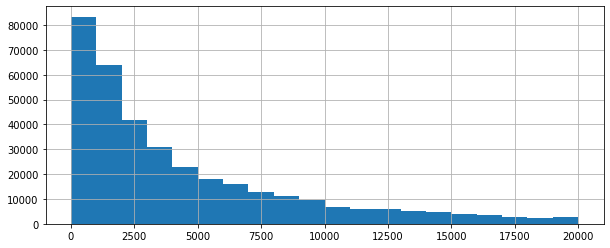

In [68]:
df["price"].hist(figsize=(10, 4), bins=20)
plt.show()

In [69]:
#Codificando las columnas de variables categóricas a numéricas
label = LabelEncoder()
df["model"] = pd.DataFrame(label.fit_transform(df["model"]))
df["brand"] = pd.DataFrame(label.fit_transform(df["brand"]))

df.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
0,480,sedan,1993,1,0,116,150000,0,petrol,38,0
1,18300,coupe,2011,1,190,159,125000,5,gasoline,1,1
2,9800,suv,2004,0,163,117,125000,8,gasoline,14,0
3,1500,small,2001,1,75,116,150000,6,petrol,38,0
4,3600,small,2008,1,69,101,90000,7,gasoline,31,0


In [70]:
df_ohe= pd.get_dummies(df, drop_first = True)
df_ohe.head()

,price,registration_year,gearbox,power,model,mileage,registration_month,brand,not_repaired,vehicle_type_convertible,...,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
0,480,1993,1,0,116,150000,0,38,0,0,...,1,0,0,0,0,0,0,0,0,1
1,18300,2011,1,190,159,125000,5,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,9800,2004,0,163,117,125000,8,14,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1500,2001,1,75,116,150000,6,38,0,0,...,0,1,0,0,0,0,0,0,0,1
4,3600,2008,1,69,101,90000,7,31,0,0,...,0,1,0,0,0,1,0,0,0,0


In [71]:
#División de características y objetos
features_ohe= df_ohe.drop(["price"], axis = 1)
target_ohe= df_ohe["price"]

In [72]:
# División de datos en conjuntos de entrenamiento y validación
random_state = 200

X_train, X_valid, y_train, y_valid = train_test_split(features_ohe,
                                                    target_ohe,
                                                    test_size=0.2,
                                                    random_state=random_state)

Vamos a entrenar al modelo con 283.495 observaciones y escoger los hiperparametros con 70.874 observaciones.

### Regresión líneal

In [73]:
%%time

#Entrenamiento del modelo
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model_preds = linear_model.predict(X_valid)

CPU times: user 258 ms, sys: 176 ms, total: 434 ms
Wall time: 441 ms


In [74]:
print(f"""
Linear Model RECM: {round(mean_squared_error(y_valid, linear_model_preds)**(1/2), 2)}
""")


Linear Model RECM: 3572.29



### Random forest

In [75]:
random_forest_model = RandomForestRegressor()

In [76]:
%%time

#hiperparámetros a buscar
distributions = dict(
    n_estimators=list(range(50, 75)),
    max_depth=list(range(3, 10))
)

rf_tuned = RandomizedSearchCV(random_forest_model, distributions, n_iter=5, cv=3, random_state=200)
rf_tuned.fit(X_train, y_train)

CPU times: user 7min 29s, sys: 675 ms, total: 7min 29s
Wall time: 7min 30s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74]},
                   random_state=200)

In [77]:
rf_preds = rf_tuned.predict(X_valid)

In [78]:
print(f"""
RF Moldel RECM: {round(mean_squared_error(y_valid, rf_preds)**(1/2), 2)}
""")


RF Moldel RECM: 2111.62



### LGBM

In [79]:
%%time

lgbm_model = lgbm.LGBMRegressor(
    learning_rate = 0.05,
    random_state = 200
)

#hiperparámetros a buscar
grid_params = {
    'max_depth': list(range(3, 10)),
    'objective': ["mean_squared_error", "mean_absolute_error"],
    'n_estimators': list(range(50, 100))
}

#modelling
lgbm_tuned = RandomizedSearchCV(lgbm_model, grid_params, cv= 3, n_jobs= -1, n_iter=5)

CPU times: user 54 µs, sys: 1e+03 ns, total: 55 µs
Wall time: 57.9 µs


In [80]:
%%time
lgbm_tuned.fit(X_train, y_train)

CPU times: user 54.8 s, sys: 219 ms, total: 55 s
Wall time: 55.3 s


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(learning_rate=0.05,
                                           random_state=200),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...],
                                        'objective': ['mean_squared_error',
                                                      'mean_absolute_error']})

In [81]:
lgbm_preds = lgbm_tuned.predict(X_valid) 

In [82]:
print(f"""
LightGBM Moldel RECM: {round(mean_squared_error(y_valid, lgbm_preds)**(1/2), 2)}
""")


LightGBM Moldel RECM: 2089.23



### CatBoost

In [83]:
%%time

CB_model = CatBoostRegressor(
    loss_function="RMSE",
    n_estimators=150,
    learning_rate=0.01,
    max_depth=5,
    random_seed=200
)

CB_model.fit(X_train, y_train, verbose=10)

CB_preds = CB_model.predict(X_valid)

0:	learn: 4484.7289364	total: 110ms	remaining: 16.4s
10:	learn: 4235.2140604	total: 657ms	remaining: 8.3s
20:	learn: 4016.7234824	total: 1.21s	remaining: 7.42s
30:	learn: 3820.7687452	total: 1.76s	remaining: 6.76s
40:	learn: 3646.3907530	total: 2.35s	remaining: 6.24s
50:	learn: 3492.8630882	total: 2.9s	remaining: 5.64s
60:	learn: 3355.4974498	total: 3.46s	remaining: 5.04s
70:	learn: 3236.1076431	total: 4.01s	remaining: 4.46s
80:	learn: 3130.6040763	total: 4.56s	remaining: 3.88s
90:	learn: 3037.5055679	total: 5.12s	remaining: 3.32s
100:	learn: 2953.7400510	total: 5.65s	remaining: 2.74s
110:	learn: 2880.0657662	total: 6.2s	remaining: 2.18s
120:	learn: 2816.0094472	total: 6.75s	remaining: 1.62s
130:	learn: 2760.3481729	total: 7.29s	remaining: 1.06s
140:	learn: 2709.7711590	total: 7.93s	remaining: 506ms
149:	learn: 2668.4474500	total: 8.43s	remaining: 0us
CPU times: user 8.5 s, sys: 35.8 ms, total: 8.54 s
Wall time: 8.88 s


In [84]:
print(f"""
CatBoost Moldel RECM: {round(mean_squared_error(y_valid, CB_preds)**(1/2), 2)}
""")


CatBoost Moldel RECM: 2671.74



### XGBoost

In [85]:
%%time

XGB_model = XGBRegressor(
    loss_function="RMSE",
    n_estimators=150,
    learning_rate=0.01,
    max_depth=5,
    random_seed=200
)

XGB_model.fit(X_train, y_train)

XGB_preds = XGB_model.predict(X_valid)

[23:38:30] WARNING: ../src/learner.cc:576: 
Parameters: { "loss_function", "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 1min 15s, sys: 232 ms, total: 1min 15s
Wall time: 1min 15s


In [87]:
print(f"""
XGBoost Moldel RECM: {round(mean_squared_error(y_valid, XGB_preds)**(1/2), 2)}
""")


XGBoost Moldel RECM: 2678.1



[Volver a Contenidos](#back)

## Conclusión <a id='end'></a>

Para crear un modelo que determine el valor de mercado para la compañía Rusty Bargain, iniciamos explorando los datos, donde el DataFrame df tiene 354.369 filas y 16 columnas, con valores ausentes, y valores duplicados. Luego, se continúo con la preparación de los datos, inspeccionando los valores únicos de cada columna, ajustando el estilo del encabezado de df, restaurando valores ausentes en la columna “not_repaired”, “VehicleType”, “FuelType”, “Gearbox”. Después de tener el DataFrame ya en orden, se inició con los entrenamientos de modelos; aplicando primero un Label Encoder para transformar las columnas “model” y “brand” de variables categóricas a numéricas. y de ahí, convertir las columnas “vehicle_type” y “fuel_type”.

Se definieron features y target, se dividieron los datos en conjuntos de entrenamiento y validación. Se entrenaron los siguientes modelos:
- Regresión lineal, su tiempo de procesamiento fue de 441 ms y su error cuadrático medio de 3572.29;
- Random forest, su tiempo de procesamiento fue de 7min 30s y su error cuadrático medio de 2111.62;
- LGBM, su tiempo de procesamiento fue de 57.9 µs y su error cuadrático medio de 2089.23;
- CatBoost, su tiempo de procesamiento fue de 8.88 s y su error cuadrático medio de 2671.74;
- XGBoost, su tiempo de procesamiento fue de 1min 15s y su error cuadrático medio de 2678.1;

Con estos resultados, se pudo concluir que el modelo XGBoost es el mejor para predecir la variable respuesta y el cuál tendrá un buen rendimiento, seguido el modelo CatBoost.